# NMF Topic Models

Topic modelling aims to automatically discover the hidden thematic structure in a large corpus of text documents. One approach for topic modelling is to apply *matrix factorisation* methods, such as *Non-negative Matrix Factorisation (NMF)*. In this notebook we look at how to apply NMF using the *scikit-learn* library in Python.

### Applying NMF

First, let's load the TF-IDF normalised document-term matrix and list of terms that we stored earlier using *Joblib*:

In [300]:
from sklearn.externals import joblib
(A,terms,snippets) = joblib.load( "articles-tfidf.pkl" ) # articles-tfidf.pkl
print( "Loaded %d X %d document-term matrix" % (A.shape[0], A.shape[1]) )

Loaded 2009 X 318 document-term matrix


The key input parameter to NMF is the number of topics to generate *k*. For the moment, we will pre-specify a guessed value, for demonstration purposes.

In [301]:
k = 50

Another choice for NMF revolves around initialisation. Most commonly, NMF involves using random initialisation to populate the values in the factors W and H. Depending on the random seed that you use, you may get different results on the same dataset. Instead, using SVD-based initialisation provides more reliable results.

In [302]:
# create the model
from sklearn import decomposition
model = decomposition.NMF( init="nndsvd", n_components=k ) 
# apply the model and extract the two factor matrices
W = model.fit_transform( A )
H = model.components_

### Examining the Output

NMF produces to factor matrices as its output: *W* and *H*.

The *W* factor contains the document membership weights relative to each of the *k* topics. Each row corresponds to a single document, and each column correspond to a topic.

In [303]:
W.shape

(2009, 50)

For instance, for the first document, we see that it is strongly associated with one topic. However,  each document can be potentially associated with multiple topics to different degrees.

In [304]:
# round to 2 decimal places for display purposes
W[0,:].round(2)

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.15, 0.  ,
       0.  , 0.  , 0.2 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

The *H* factor contains the term weights relative to each of the *k* topics. In this case, each row corresponds to a topic, and each column corresponds to a unique term in the corpus vocabulary.

In [305]:
H.shape

(50, 318)

For instance, for the term "light", we see that it is strongly associated with a single topic. Again, in some cases each term can be associated with multiple topics.

In [306]:
term_index = terms.index('light')
# round to 2 decimal places for display purposes
H[:,term_index].round(2)

array([9.82, 0.  , 0.  , 0.  , 0.  , 0.03, 0.  , 0.  , 0.  , 0.  , 0.02,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.16, 0.  , 0.  , 0.01, 0.01, 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.14, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.09, 0.  , 0.  , 0.  , 0.  ])

### Topic Descriptors

The top ranked terms from the *H* factor for each topic can give us an insight into the content of that topic. This is often called the *topic descriptor*. Let's define a function that extracts the descriptor for a specified topic: 

In [307]:
import numpy as np
def get_descriptor( terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( terms[term_index] )
    return top_terms

We can now get a descriptor for each topic using the top ranked terms (e.g. top 10):

In [308]:
descriptors = []
for topic_index in range(k):
    descriptors.append( get_descriptor( terms, H, topic_index, 10 ) )
    str_descriptor = ", ".join( descriptors[topic_index] )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: light, travels, source, hits, straight, understanding, waves, solar, shine, chemiluminescence
Topic 02: blood, cells, red, oxygen, veins, vessels, marrow, skin, form, carry
Topic 03: water, filter, drink, sugar, humans, way, ground, world, need, hard
Topic 04: red, green, blue, rose, cones, eye, absorbed, yellow, eyes, reflected
Topic 05: moss, grow, spores, grows, seeds, plant, north, wind, trees, types
Topic 06: see, transparent, eyes, rose, bounces, far, glass, able, translucent, eye
Topic 07: brain, part, controls, stem, cerebrum, parts, spinal, cord, important, sends
Topic 08: food, stomach, digest, take, mouth, queen, long, breaks, break, esophagus
Topic 09: sun, moon, eclipse, earth, solar, lunar, blocks, front, learned, shadow
Topic 10: ants, information, build, sleep, queen, insects, dirt, move, turn, main
Topic 11: mirror, concave, looks, bounces, side, flat, right, shape, head, away
Topic 12: google, docs, edit, link, lots, acids, learned, source, find, picture
Top

The rankings above do not show the strength of association for the different terms. We can represent the distribution of the weights for the top terms in a topic using a *matplotlib* horizontal bar chart.

In [309]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.style.use("ggplot")
matplotlib.rcParams.update({"font.size": 14})

Define a function to create a bar chart for the specified topic, based on the *H* factor from the current NMF model:

In [310]:
def plot_top_term_weights( terms, H, topic_index, top ):
    # get the top terms and their weights
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    top_terms = []
    top_weights = []
    for term_index in top_indices[0:top]:
        top_terms.append( terms[term_index] )
        top_weights.append( H[topic_index,term_index] )
    # note we reverse the ordering for the plot
    top_terms.reverse()
    top_weights.reverse()
    # create the plot
    fig = plt.figure(figsize=(13,8))
    # add the horizontal bar chart
    ypos = np.arange(top)
    ax = plt.barh(ypos, top_weights, align="center", color="green",tick_label=top_terms)
    plt.xlabel("Term Weight",fontsize=14)
    plt.tight_layout()
    plt.show()

So for instance, for the 7th topic we can generate a plot with the top 15 terms using:

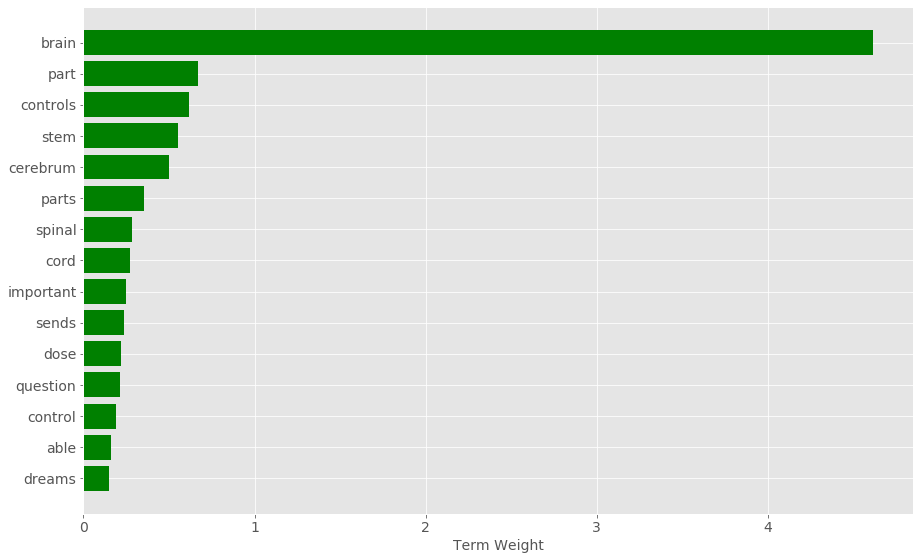

In [311]:
plot_top_term_weights( terms, H, 6, 15 )

### Most Relevant Documents

We can also look at the snippets for the top-ranked documents for each topic. We'll define a function to produce this ranking also.

In [312]:
def get_top_snippets( all_snippets, W, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( W[:,topic_index] )[::-1]
    # now get the snippets corresponding to the top-ranked indices
    top_snippets = []
    for doc_index in top_indices[0:top]:
        top_snippets.append( all_snippets[doc_index] )
    return top_snippets

For instance, for the first topic listed above, the top 10 documents are:

In [313]:
topic_snippets = get_top_snippets( snippets, W, 0, 10 )
for i, snippet in enumerate(topic_snippets):
    print("%02d. %s" % ( (i+1), snippet ) )

01. it dost focus the light
02. lasers are the best wielding equipment that i no of because it saved the navy millions laser is shor
03. some lenses make light spread out
04. lasers are very highly bright and intense light they can burn though anything
05. lasers are very highly bright and intense light it can burn through anything
06. there are 2 rinds of light natural and artificial the kind of light that is in your home is artifici
07. water bends light
08. there are two kinds of light natural and artificial natural light is light from a natural light sour
09. all we see is light
10. all we see is light without light we can not see


Similarly, for the second topic:

In [314]:
topic_snippets = get_top_snippets( snippets, W, 1, 10 )
for i, snippet in enumerate(topic_snippets):
    print("%02d. %s" % ( (i+1), snippet ) )

01. mosquito bites can be so powerfull that they can crush blood vesls
02. white blood cells are different than red blood cells white blood cells fight sicknesses by blobbing 
03. white blood cells are like blobs they blob up all the bad things red blood cells are what make up yo
04. the plasma in your blood makes up 50 to 55 of blood also there is water in plasma red blood cells ma
05. aorta: tackes oxgenrich blood to the bodyarturies: brings blood to the body
06. different blood types then hemolysis the destruction of red blood cells can occur hemolysis can caus
07. the pulmonary vein collects the blood cells after the oxygen travels through the trachea and attache
08. that is what i was thinking because white blood cells fight off sicknesess
09. white blood cells clean the infection
10. the questions i have now are white blood cells are the same or different than red blood cells


### Exporting the Results

If we want to keep this topic model for later user, we can save it using *joblib*:

In [315]:
joblib.dump((W,H,terms,snippets), "articles-model-nmf-k%02d.pkl" % k) 

['articles-model-nmf-k50.pkl']